In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

## 1. Data Loading and Preparation

In [ ]:
# Load the survey data
df = pd.read_stata('ZA10000_v2-0-0/ZA10000_v2-0-0.dta')

# Load variable descriptions
with open('data/2022/ZA10000_variables_short.json', 'r') as f:
    variables = json.load(f)

# Load country mapping
with open('data/2022/country.json', 'r') as f:
    country_data = json.load(f)

print(f"Total records: {len(df):,}")
print(f"Total variables: {len(df.columns)}")

Total records: 45,762
Total variables: 417


In [ ]:
# Map country codes to names
df['country_name'] = df['c_alphan'].map(country_data)

# Filter for women only
df_women = df[df['SEX'].astype(str).str.contains('Female', na=False)].copy()
print(f"Total female respondents: {len(df_women):,}")

# Filter for women with partners
df_women_partnered = df_women[df_women['PARTLIV'].astype(str).str.contains('Yes', na=False)].copy()
print(f"Female respondents with partners: {len(df_women_partnered):,}")

Total female respondents: 24,763
Female respondents with partners: 15,867


## 2. Helper Function for Data Cleaning

The data comes with categorical labels like "0. None", "1. 1 to less than 5 hours", etc.
We need to extract the numeric codes.

In [ ]:
def extract_numeric(val):
    """Extract numeric code from categorical variable labels"""
    if pd.isna(val):
        return np.nan
    val_str = str(val)
    # Handle negative codes (like -9 for "No answer")
    if val_str.startswith('-'):
        try:
            return float(val_str.split('.')[0])
        except:
            return np.nan
    # Extract positive codes
    try:
        return float(val_str.split('.')[0])
    except:
        return np.nan

## 3. Key Variables Definition

In [ ]:
# Define key variables for analysis
practical_support_vars = {
    'v34': 'Hours: R on household work',
    'v35': 'Hours: R on family care',
    'v36': 'Hours: Partner on household work',
    'v37': 'Hours: Partner on family care',
    'v38': 'Income sharing',
    'v39': 'Division: Laundry',
    'v40': 'Division: Plan activities',
    'v41': 'Division: Care for sick',
    'v42': 'Division: Shop groceries',
    'v43': 'Division: Cleaning',
    'v44': 'Division: Prepare meals',
    'v45': 'Overall household work sharing',
    'SPWORK': 'Partner employment status',
    'SPWRKHRS': 'Partner work hours',
    'WORK': 'R employment status',
    'WRKHRS': 'R work hours'
}

print("Key Variables:")
for var, desc in practical_support_vars.items():
    if var in variables:
        print(f"  {var}: {variables[var]}")

Key Variables:
  v34: Q15a How many hours spend on household work
  v35: Q15b How many hours spend on family members
  v36: Q16a How many hours spouse, partner works on household
  v37: Q16b How many hrs spouse, partner spends on family members
  v38: Q17 Sharing of income between partners
  v39: Q18a Division of household work: doing the laundry
  v40: Q18b Division of household work: plan social/family activities
  v41: Q18c Division of household work: care for sick family members
  v42: Q18d Division of household work: shops for groceries
  v43: Q18e Division of household work: household cleaning
  v44: Q18f Division of household work: preparing meals
  v45: Q19 Sharing of household work between partners
  SPWORK: Spouse, partner: currently, formerly or never in paid work
  SPWRKHRS: Spouse, partner: hours worked weekly
  WORK: Currently, formerly, or never in paid work
  WRKHRS: Hours worked weekly


## 4. Data Cleaning and Conversion

In [ ]:
# Convert time variables to numeric
# Use .loc to avoid SettingWithCopyWarning and ensure proper assignment
df_women_partnered.loc[:, 'v34_num'] = df_women_partnered['v34'].apply(extract_numeric).astype(float)
df_women_partnered.loc[:, 'v35_num'] = df_women_partnered['v35'].apply(extract_numeric).astype(float)
df_women_partnered.loc[:, 'v36_num'] = df_women_partnered['v36'].apply(extract_numeric).astype(float)
df_women_partnered.loc[:, 'v37_num'] = df_women_partnered['v37'].apply(extract_numeric).astype(float)

# Create binary employment variable
df_women_partnered['is_working'] = (
    df_women_partnered['WORK'].astype(str).str.contains('Currently in paid work', na=False)
).astype(int)

# Create simplified work status
df_women_partnered['work_simple'] = df_women_partnered['WORK'].astype(str).apply(
    lambda x: 'Working' if 'Currently in paid work' in x else 'Not Working'
)

working_count = int(df_women_partnered['is_working'].sum())
not_working_count = len(df_women_partnered) - working_count

print(f"Working women: {working_count:,} ({working_count/len(df_women_partnered)*100:.1f}%)")
print(f"Not working women: {not_working_count:,} ({not_working_count/len(df_women_partnered)*100:.1f}%)")

Working women: 9,601 (60.5%)
Not working women: 6,266 (39.5%)


## 5. Missing Data Analysis

In [ ]:
# Check missing values in key variables
key_vars = list(practical_support_vars.keys())
missing_data = df_women_partnered[key_vars].isnull().sum()
missing_pct = (missing_data / len(df_women_partnered) * 100).round(2)

missing_df = pd.DataFrame({
    'Variable': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing %': missing_pct.values
}).sort_values('Missing %', ascending=False)

print("Missing Data Analysis:")
print(missing_df.head(10))

Missing Data Analysis:
  Variable  Missing Count  Missing %
0      v34              0        0.0
1      v35              0        0.0
2      v36              0        0.0
3      v37              0        0.0
4      v38              0        0.0
5      v39              0        0.0
6      v40              0        0.0
7      v41              0        0.0
8      v42              0        0.0
9      v43              0        0.0


## 6. Women's Employment Status Distribution

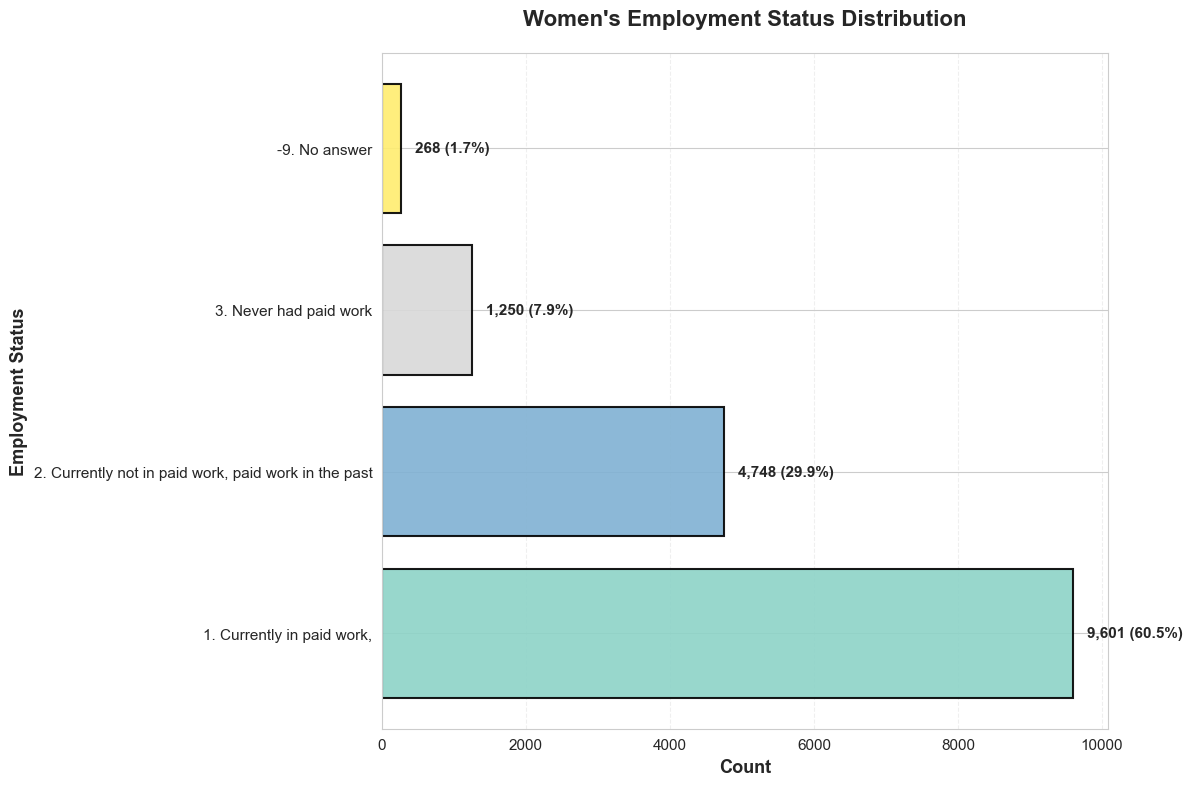

In [ ]:
# Women's employment status distribution
work_status_counts = df_women_partnered['WORK'].value_counts()

fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(work_status_counts)))
bars = ax.barh(range(len(work_status_counts)), work_status_counts.values, 
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.9)
ax.set_yticks(range(len(work_status_counts)))
ax.set_yticklabels(work_status_counts.index, fontsize=11)
ax.set_title('Women\'s Employment Status Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Count', fontsize=13, fontweight='bold')
ax.set_ylabel('Employment Status', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, v in enumerate(work_status_counts.values):
    pct = v / work_status_counts.sum() * 100
    ax.text(v + work_status_counts.max()*0.02, i, f'{v:,} ({pct:.1f}%)', 
            va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


## 7. Time Allocation Analysis

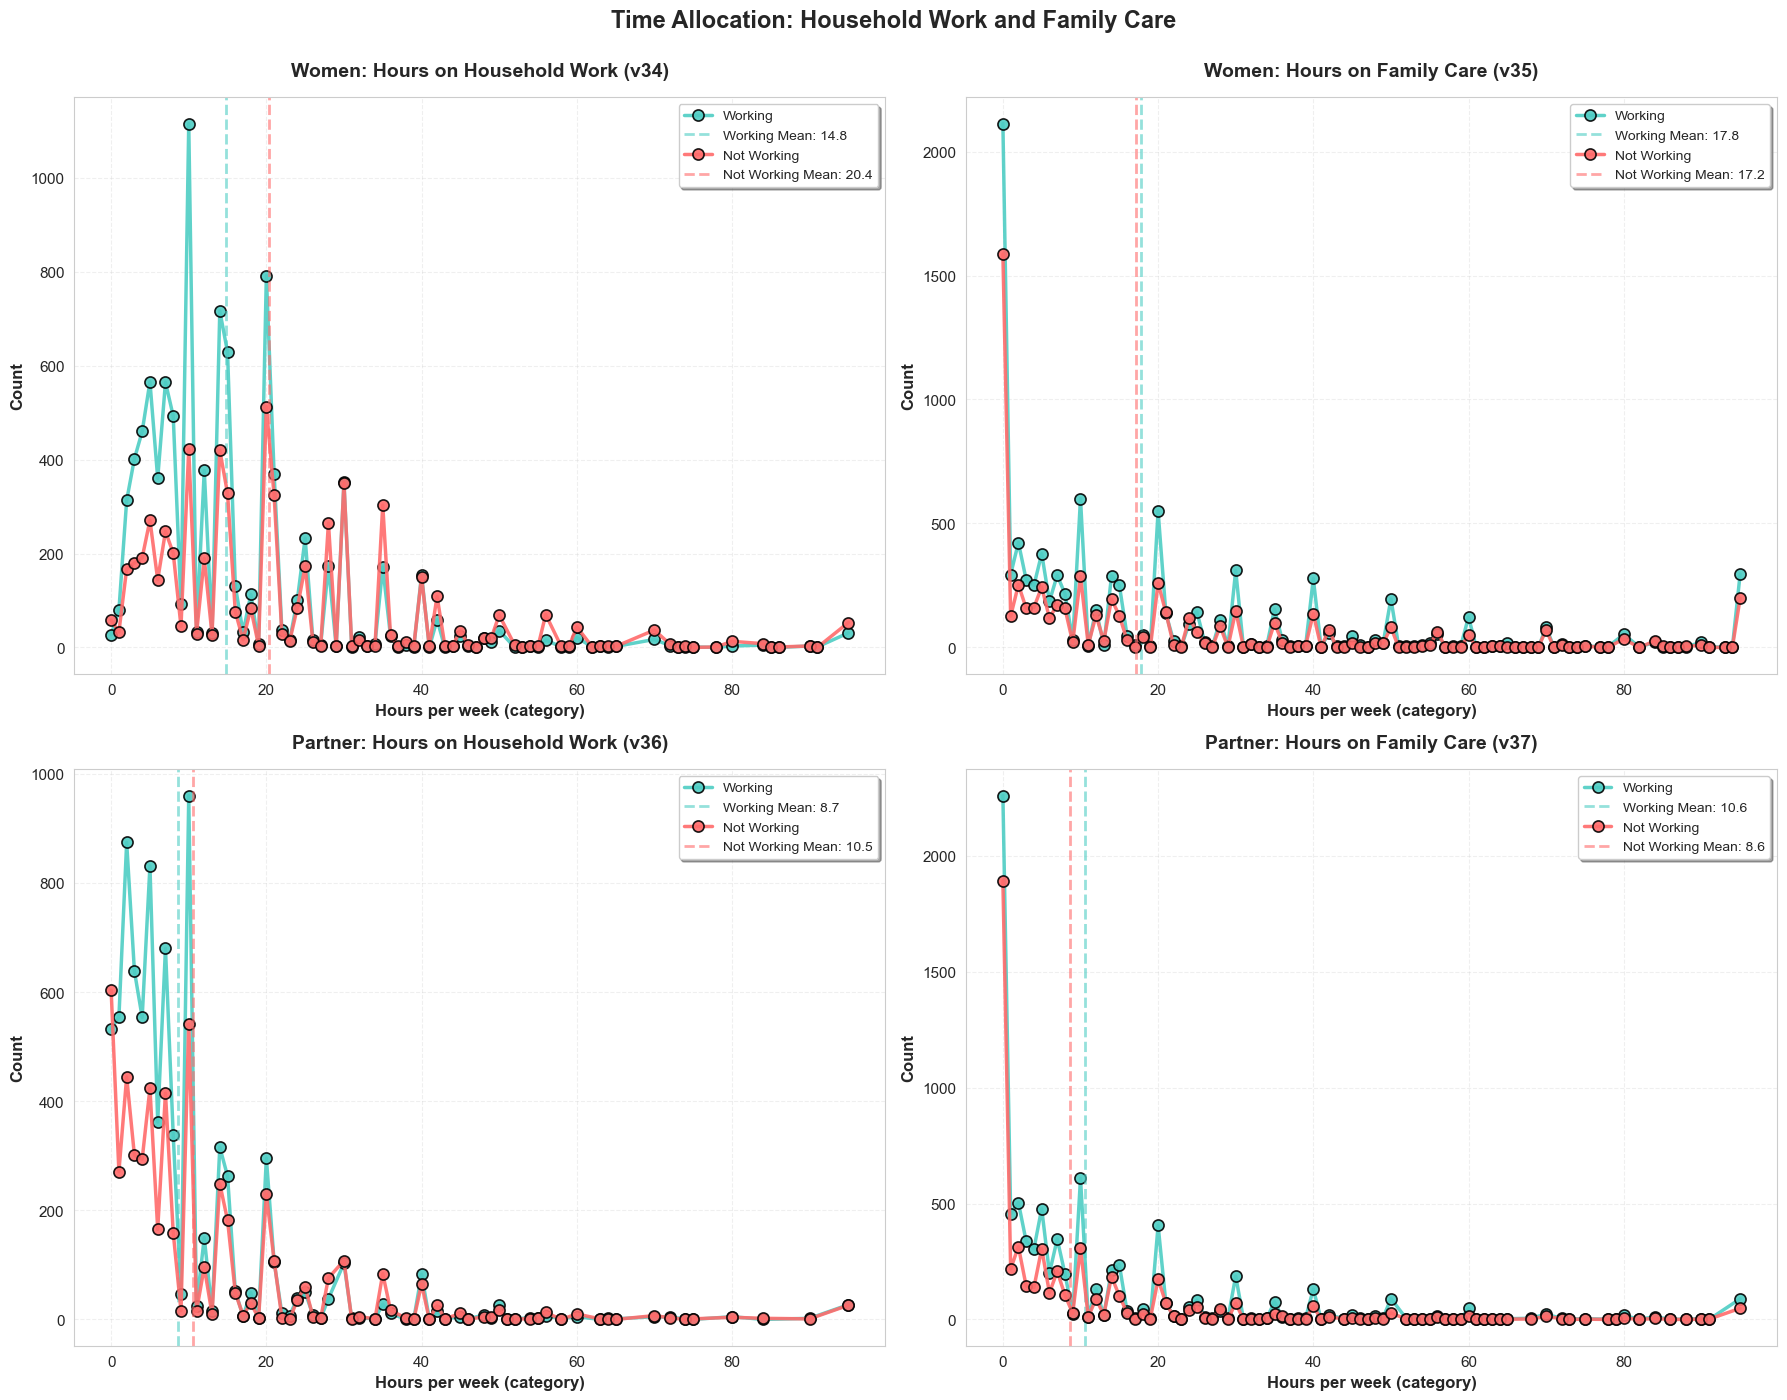


Summary Statistics (excluding missing values):

Women's Household Work Hours:
count    15258.000000
mean        16.940556
std         13.939351
min          0.000000
25%          7.000000
50%         14.000000
75%         21.000000
max         95.000000
Name: v34_num, dtype: float64

Partner's Household Work Hours:
count    13387.000000
mean         9.402256
std         11.328572
min          0.000000
25%          3.000000
50%          6.000000
75%         11.000000
max         95.000000
Name: v36_num, dtype: float64


In [ ]:
# Distribution of time spent on household work and family care
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Filter out negative values and plot by employment status
def plot_time_distribution_by_status(ax, var_name, title):
    # Colors for working vs not working
    color_working = '#4ECDC4'  # Teal for working
    color_not_working = '#FF6B6B'  # Coral for not working
    
    # Collect data for both statuses
    all_categories = set()
    data_by_status = {}
    
    for status, color in [('Working', color_working), ('Not Working', color_not_working)]:
        # Filter by work status
        df_status = df_women_partnered[df_women_partnered['work_simple'] == status]
        
        # Ensure data is numeric and drop NaN values
        data_numeric = pd.to_numeric(df_status[var_name], errors='coerce').dropna()
        valid_data = data_numeric[data_numeric >= 0]
        
        if len(valid_data) > 0:
            counts = valid_data.value_counts().sort_index()
            data_by_status[status] = counts
            all_categories.update(counts.index)
    
    # Sort categories and prepare data
    all_categories = sorted(all_categories)
    
    # Plot lines for each status and calculate means
    for status, color in [('Working', color_working), ('Not Working', color_not_working)]:
        if status in data_by_status:
            counts = data_by_status[status]
            heights = [counts.get(cat, 0) for cat in all_categories]
            ax.plot(all_categories, heights, color=color, alpha=0.9, 
                   linewidth=2.5, marker='o', markersize=8, 
                   label=status, markeredgecolor='black', markeredgewidth=1.2)
            
            # Calculate and plot mean
            df_status = df_women_partnered[df_women_partnered['work_simple'] == status]
            data_numeric = pd.to_numeric(df_status[var_name], errors='coerce').dropna()
            valid_data = data_numeric[data_numeric >= 0]
            if len(valid_data) > 0:
                mean_val = valid_data.mean()
                ax.axvline(mean_val, color=color, linestyle='--', linewidth=2, 
                          alpha=0.6, label=f'{status} Mean: {mean_val:.1f}')
    
    ax.set_title(title, fontweight='bold', fontsize=14, pad=15)
    ax.set_xlabel('Hours per week (category)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10, frameon=True, shadow=True, loc='best')
    ax.grid(alpha=0.3, linestyle='--')


plot_time_distribution_by_status(axes[0, 0], 'v34_num',
                                  'Women: Hours on Household Work (v34)')
plot_time_distribution_by_status(axes[0, 1], 'v35_num',
                                  'Women: Hours on Family Care (v35)')
plot_time_distribution_by_status(axes[1, 0], 'v36_num',
                                  'Partner: Hours on Household Work (v36)')
plot_time_distribution_by_status(axes[1, 1], 'v37_num',
                                  'Partner: Hours on Family Care (v37)')

plt.suptitle('Time Allocation: Household Work and Family Care', 
             fontsize=17, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics (excluding missing values):")
print("\nWomen's Household Work Hours:")
v34_numeric = pd.to_numeric(df_women_partnered['v34_num'], errors='coerce')
print(v34_numeric[v34_numeric >= 0].describe())
print("\nPartner's Household Work Hours:")
v36_numeric = pd.to_numeric(df_women_partnered['v36_num'], errors='coerce')
print(v36_numeric[v36_numeric >= 0].describe())

## 8. Partner's Household Contribution by Women's Employment Status

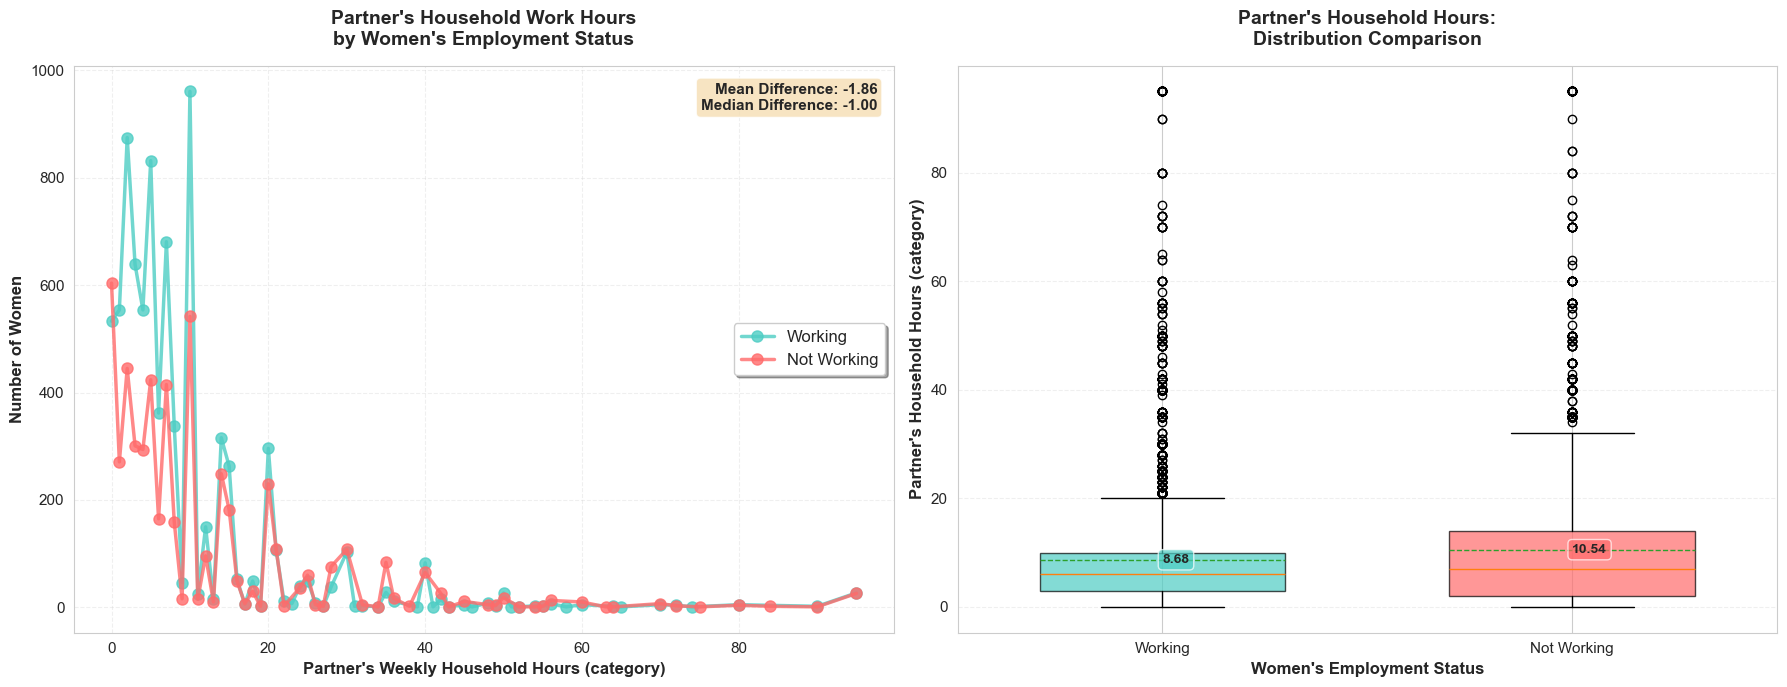

PARTNER'S HOUSEHOLD CONTRIBUTION ANALYSIS

Working Women's Partners:
  Mean: 8.68
  Median: 6.00
  Std Dev: 10.33
  Sample size: 8,171

Not Working Women's Partners:
  Mean: 10.54
  Median: 7.00
  Std Dev: 12.65
  Sample size: 5,216

Differences:
  Mean difference: -1.86 (partners of working women do 1.86 less)
  Median difference: -1.00
  Effect size (Cohen's d): -0.161


In [ ]:
# Analyze partner's household hours by women's employment status
# Filter for valid data (>= 0) - ensure numeric conversion first
v36_numeric = pd.to_numeric(df_women_partnered['v36_num'], errors='coerce')
df_valid = df_women_partnered[v36_numeric >= 0].copy()
df_valid.loc[:, 'v36_num'] = pd.to_numeric(df_valid['v36_num'], errors='coerce')

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Calculate statistics for annotations
working_data = df_valid[df_valid['work_simple'] == 'Working']['v36_num']
not_working_data = df_valid[df_valid['work_simple'] == 'Not Working']['v36_num']
mean_working = working_data.mean()
mean_not_working = not_working_data.mean()
median_working = working_data.median()
median_not_working = not_working_data.median()
diff_mean = mean_working - mean_not_working
diff_median = median_working - median_not_working

# Plot 1: Distribution by work status
colors = {'Working': '#4ECDC4', 'Not Working': '#FF6B6B'}
for status in ['Working', 'Not Working']:
    data = pd.to_numeric(df_valid[df_valid['work_simple'] == status]['v36_num'], errors='coerce')
    counts = data.value_counts().sort_index()
    axes[0].plot(counts.index, counts.values, marker='o', linewidth=2.5, 
                markersize=8, label=status, alpha=0.8, color=colors[status])

axes[0].set_title('Partner\'s Household Work Hours\nby Women\'s Employment Status', 
                 fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Partner\'s Weekly Household Hours (category)', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Women', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=12, frameon=True, shadow=True)
axes[0].grid(alpha=0.3, linestyle='--')

# Add text annotation with key statistics
textstr = f'Mean Difference: {diff_mean:+.2f}\nMedian Difference: {diff_median:+.2f}'
axes[0].text(0.98, 0.97, textstr, transform=axes[0].transAxes,
            fontsize=11, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontweight='bold')

# Plot 2: Box plot comparison
work_data = [df_valid[df_valid['work_simple'] == 'Working']['v36_num'],
             df_valid[df_valid['work_simple'] == 'Not Working']['v36_num']]
bp = axes[1].boxplot(work_data, labels=['Working', 'Not Working'], patch_artist=True,
                     widths=0.6, showmeans=True, meanline=True)
plot_colors = ['#4ECDC4', '#FF6B6B']
for patch, color in zip(bp['boxes'], plot_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_title('Partner\'s Household Hours:\nDistribution Comparison', 
                 fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Women\'s Employment Status', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Partner\'s Household Hours (category)', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Add annotations showing means
axes[1].text(1, mean_working, f'{mean_working:.2f}', 
            ha='left', va='center', fontweight='bold', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#4ECDC4', alpha=0.7))
axes[1].text(2, mean_not_working, f'{mean_not_working:.2f}', 
            ha='left', va='center', fontweight='bold', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#FF6B6B', alpha=0.7))

plt.tight_layout()
plt.show()

# Print detailed statistics
print("="*70)
print("PARTNER'S HOUSEHOLD CONTRIBUTION ANALYSIS")
print("="*70)
print(f"\nWorking Women's Partners:")
print(f"  Mean: {mean_working:.2f}")
print(f"  Median: {median_working:.2f}")
print(f"  Std Dev: {working_data.std():.2f}")
print(f"  Sample size: {len(working_data):,}")

print(f"\nNot Working Women's Partners:")
print(f"  Mean: {mean_not_working:.2f}")
print(f"  Median: {median_not_working:.2f}")
print(f"  Std Dev: {not_working_data.std():.2f}")
print(f"  Sample size: {len(not_working_data):,}")

print(f"\nDifferences:")
print(f"  Mean difference: {diff_mean:+.2f} (partners of working women do {abs(diff_mean):.2f} {'more' if diff_mean > 0 else 'less'})")
print(f"  Median difference: {diff_median:+.2f}")
print(f"  Effect size (Cohen's d): {(mean_working - mean_not_working) / np.sqrt((working_data.std()**2 + not_working_data.std()**2) / 2):.3f}")
print("="*70)

<!-- ### Interpretation: Partner's Household Contribution

**What This Plot Shows:**

The visualization compares how much household work partners do based on whether the woman is employed or not.

**Line Plot (Left):**
- Shows the frequency distribution of partner's household hours
- Each peak represents a common response category (e.g., "5-9 hours", "10-14 hours")
- Compare the shapes: Where do working vs non-working women's partners cluster?

**Box Plot (Right):**
- The box shows the middle 50% of responses (25th to 75th percentile)
- The line inside the box is the median (50th percentile)
- The green line with triangle markers shows the mean
- Whiskers extend to show the range of typical values

**Key Insights to Look For:**

1. **Mean/Median Comparison**: If partners of working women have higher means, they contribute MORE household hours
2. **Distribution Overlap**: Heavily overlapping boxes suggest similar patterns; separated boxes indicate clear differences
3. **Spread**: Wider boxes indicate more variability in how couples divide household work
4. **Effect Size**: The printed Cohen's d tells you if the difference is practically meaningful:
   - Small effect: d ≈ 0.2
   - Medium effect: d ≈ 0.5
   - Large effect: d ≈ 0.8

**Research Question Context:**

This addresses whether partners increase their household contributions when women work, which could be:
- **Compensatory**: Partners pick up more household work to enable women's employment
- **Equity-based**: Dual-earner couples share household work more equally
- **No relationship**: Partner contributions remain similar regardless of women's work status -->

## 9. Average Partner Support by Women's Employment Status

Average Partner Support by Women's Employment Status:

             Household Work  Family Care
work_simple                             
Not Working           10.51         8.69
Working                8.73        10.60

T-test (Partner's Household Hours):
  t-statistic: -8.6570
  p-value: 0.0000
  Significant: Yes (α=0.05)


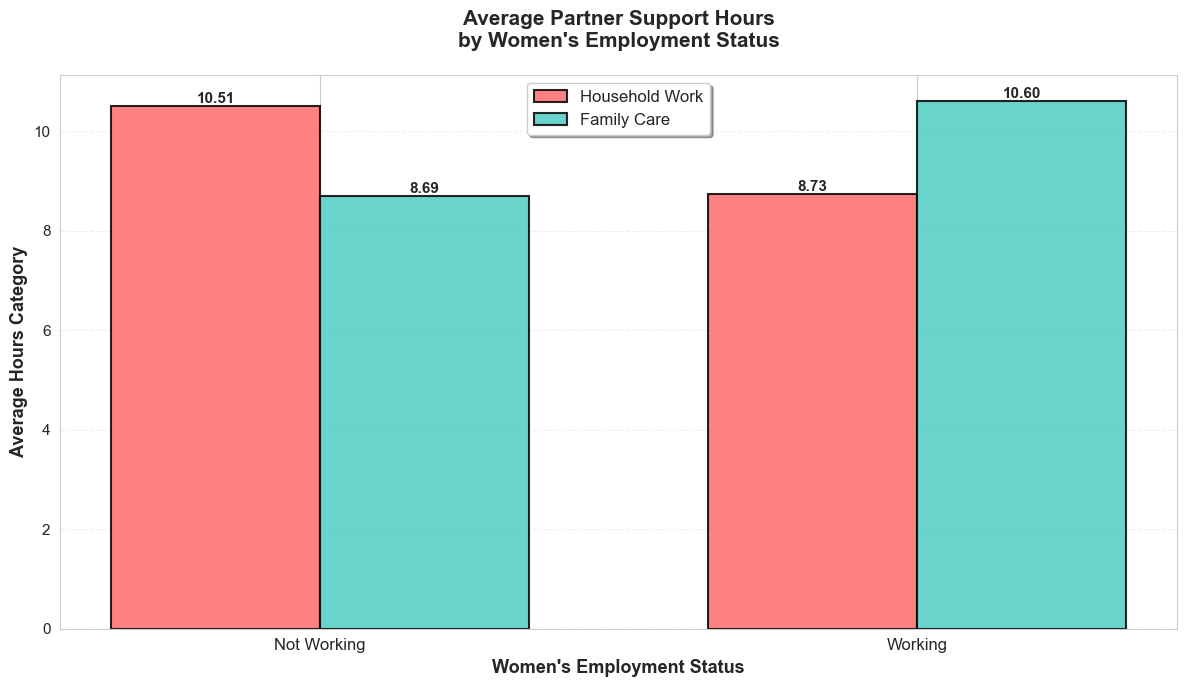

In [ ]:
# Calculate average partner support (excluding negative values)
# Ensure numeric conversion before filtering
v36_numeric = pd.to_numeric(df_women_partnered['v36_num'], errors='coerce')
v37_numeric = pd.to_numeric(df_women_partnered['v37_num'], errors='coerce')

df_valid_support = df_women_partnered[
    (v36_numeric >= 0) & (v37_numeric >= 0)
].copy()

# Reassign numeric columns to ensure they're properly typed
df_valid_support.loc[:, 'v36_num'] = pd.to_numeric(df_valid_support['v36_num'], errors='coerce')
df_valid_support.loc[:, 'v37_num'] = pd.to_numeric(df_valid_support['v37_num'], errors='coerce')

avg_support = df_valid_support.groupby('work_simple')[['v36_num', 'v37_num']].mean()
avg_support.columns = ['Household Work', 'Family Care']

print("Average Partner Support by Women's Employment Status:")
print("\n" + "="*70)
print(avg_support.round(2))
print("="*70)

# Statistical test
working_v36 = df_valid_support[df_valid_support['work_simple'] == 'Working']['v36_num']
not_working_v36 = df_valid_support[df_valid_support['work_simple'] == 'Not Working']['v36_num']
t_stat, p_value = stats.ttest_ind(working_v36, not_working_v36)
print(f"\nT-test (Partner's Household Hours):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

# Visualize
fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(avg_support.index))
width = 0.35

bars1 = ax.bar(x - width/2, avg_support['Household Work'], width, 
               label='Household Work', color='#FF6B6B', 
               edgecolor='black', linewidth=1.5, alpha=0.85)
bars2 = ax.bar(x + width/2, avg_support['Family Care'], width, 
               label='Family Care', color='#4ECDC4', 
               edgecolor='black', linewidth=1.5, alpha=0.85)

ax.set_title('Average Partner Support Hours\nby Women\'s Employment Status', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel('Women\'s Employment Status', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Hours Category', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(avg_support.index, fontsize=12)
ax.legend(fontsize=12, frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

## 10. Division of Specific Household Tasks

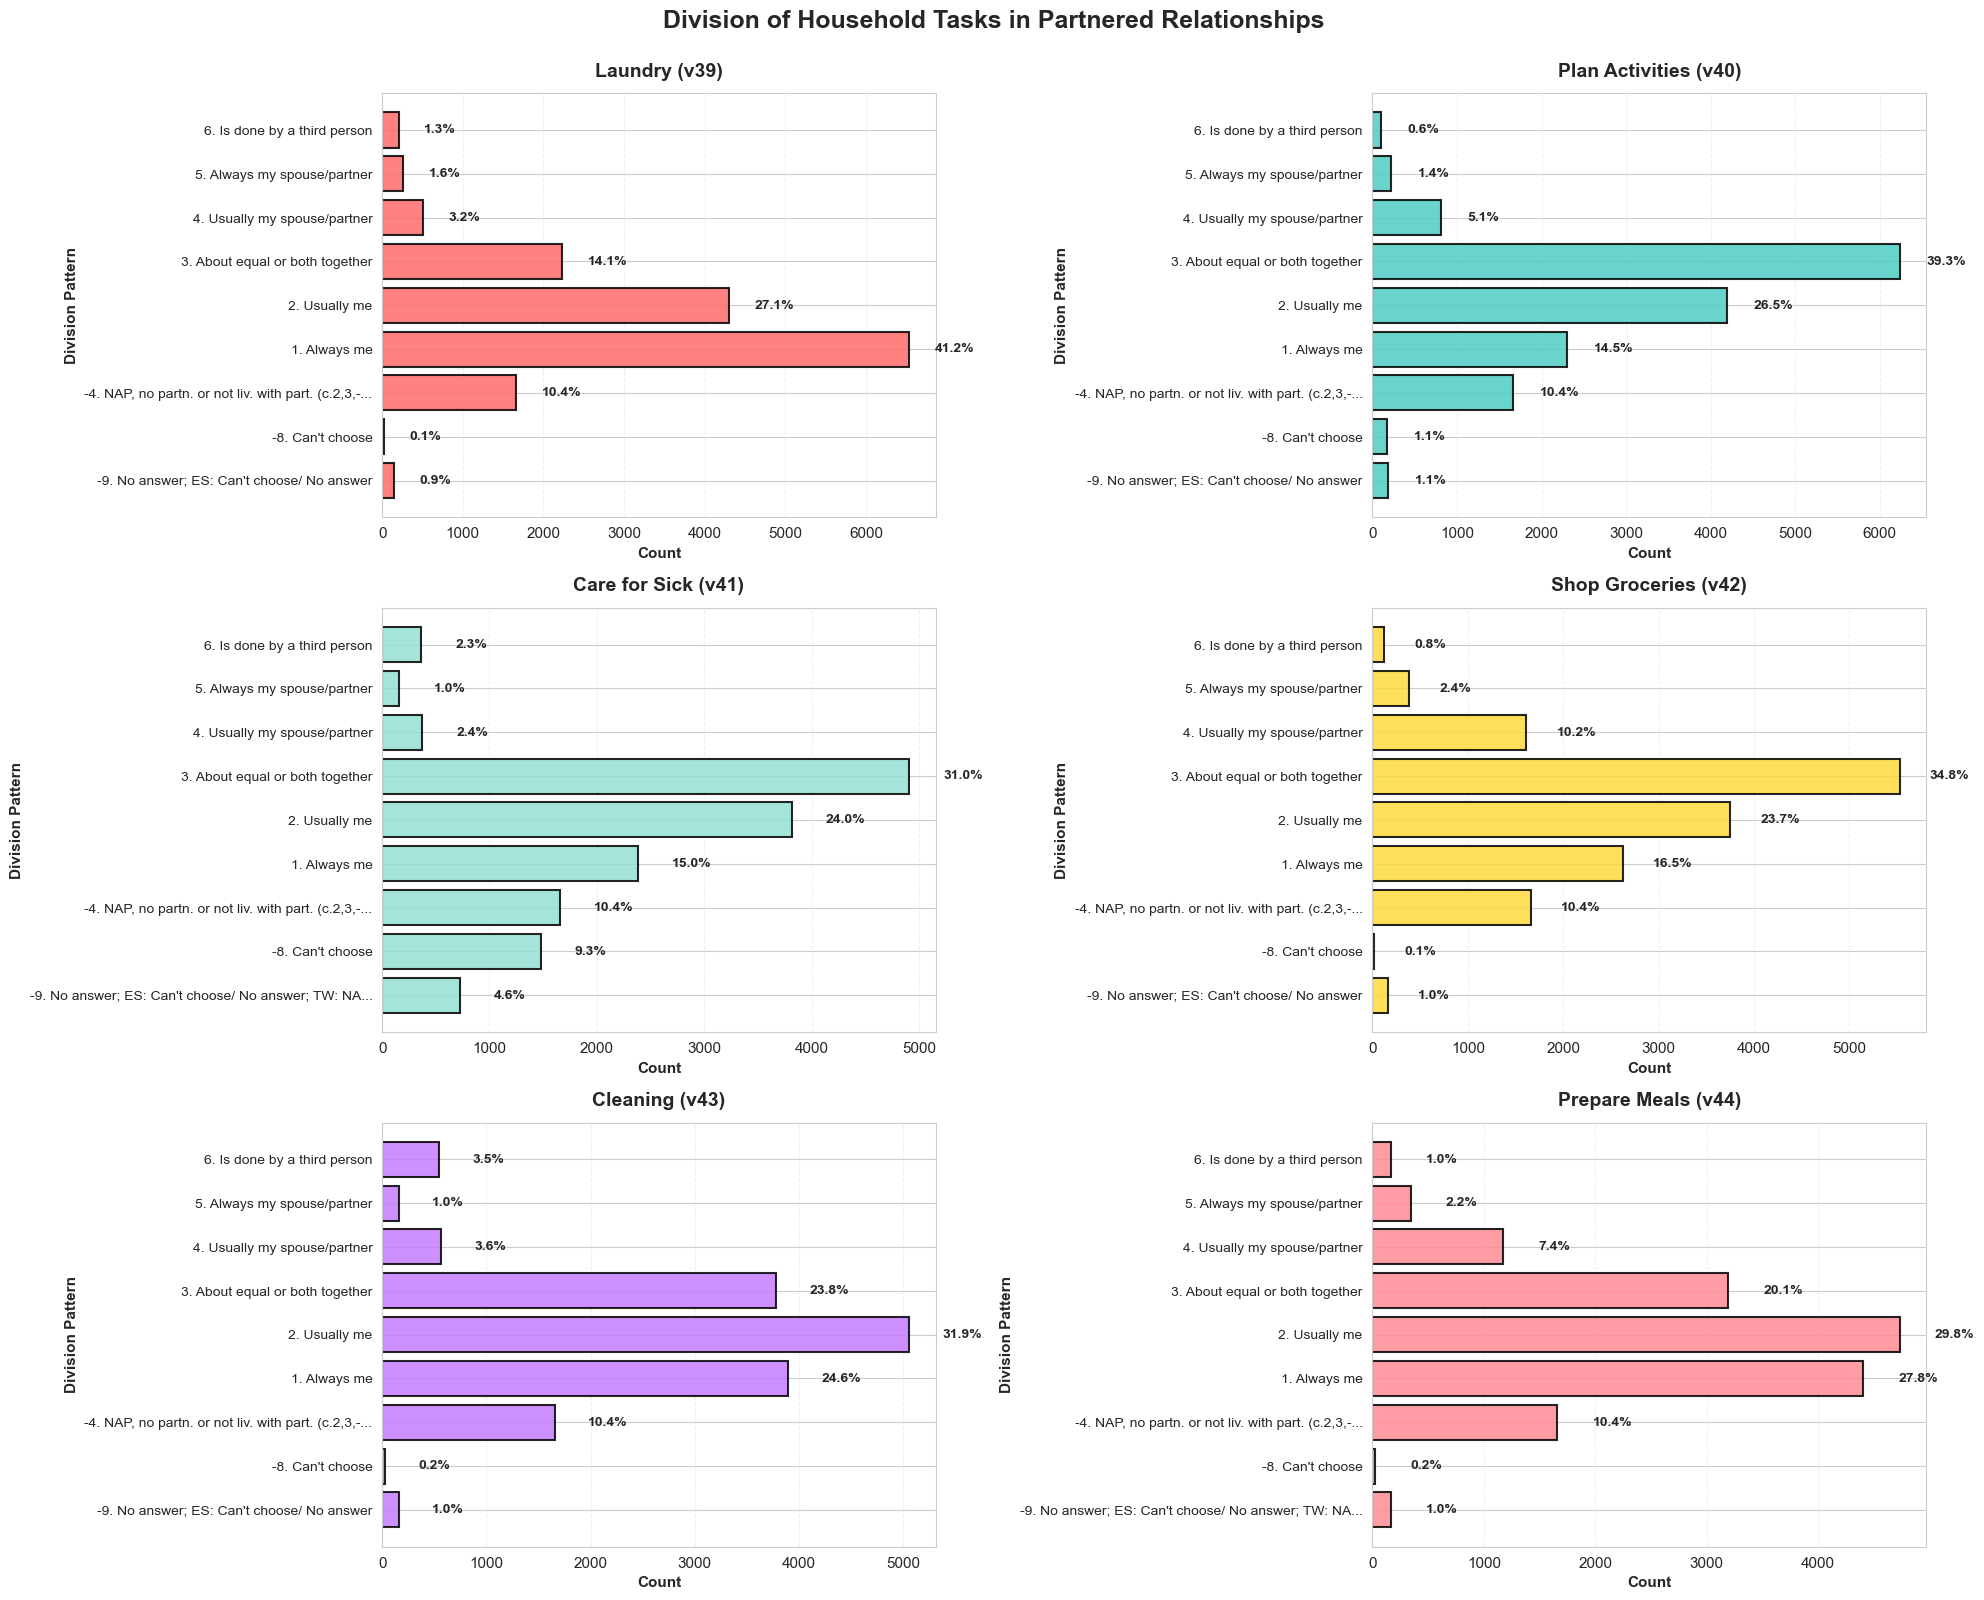

In [ ]:
# Analyze division of specific household tasks
task_vars = ['v39', 'v40', 'v41', 'v42', 'v43', 'v44']
task_names = ['Laundry', 'Plan Activities', 'Care for Sick', 
              'Shop Groceries', 'Cleaning', 'Prepare Meals']

fig, axes = plt.subplots(3, 2, figsize=(20, 16))
axes = axes.flatten()
colors_palette = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#FFD93D', '#C77DFF', '#FF8B94']

for idx, (var, name) in enumerate(zip(task_vars, task_names)):
    task_dist = df_women_partnered[var].value_counts().sort_index()
    if len(task_dist) > 0:
        bars = axes[idx].barh(range(len(task_dist)), task_dist.values, 
                             color=colors_palette[idx], alpha=0.85, 
                             edgecolor='black', linewidth=1.5)
        axes[idx].set_yticks(range(len(task_dist)))
        # Truncate long labels
        labels = [str(label)[:50] + '...' if len(str(label)) > 50 else str(label) 
                 for label in task_dist.index]
        axes[idx].set_yticklabels(labels, fontsize=10)
        axes[idx].set_title(f'{name} ({var})', fontweight='bold', fontsize=14, pad=12)
        axes[idx].set_xlabel('Count', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Division Pattern', fontsize=11, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add percentage labels
        total = task_dist.sum()
        for i, v in enumerate(task_dist.values):
            pct = v / total * 100
            axes[idx].text(v + total*0.02, i, f'{pct:.1f}%', 
                          va='center', fontsize=10, fontweight='bold')

plt.suptitle('Division of Household Tasks in Partnered Relationships', 
             fontsize=18, fontweight='bold', y=0.998)
plt.tight_layout()
plt.show()

## 11. Overall Household Work Sharing

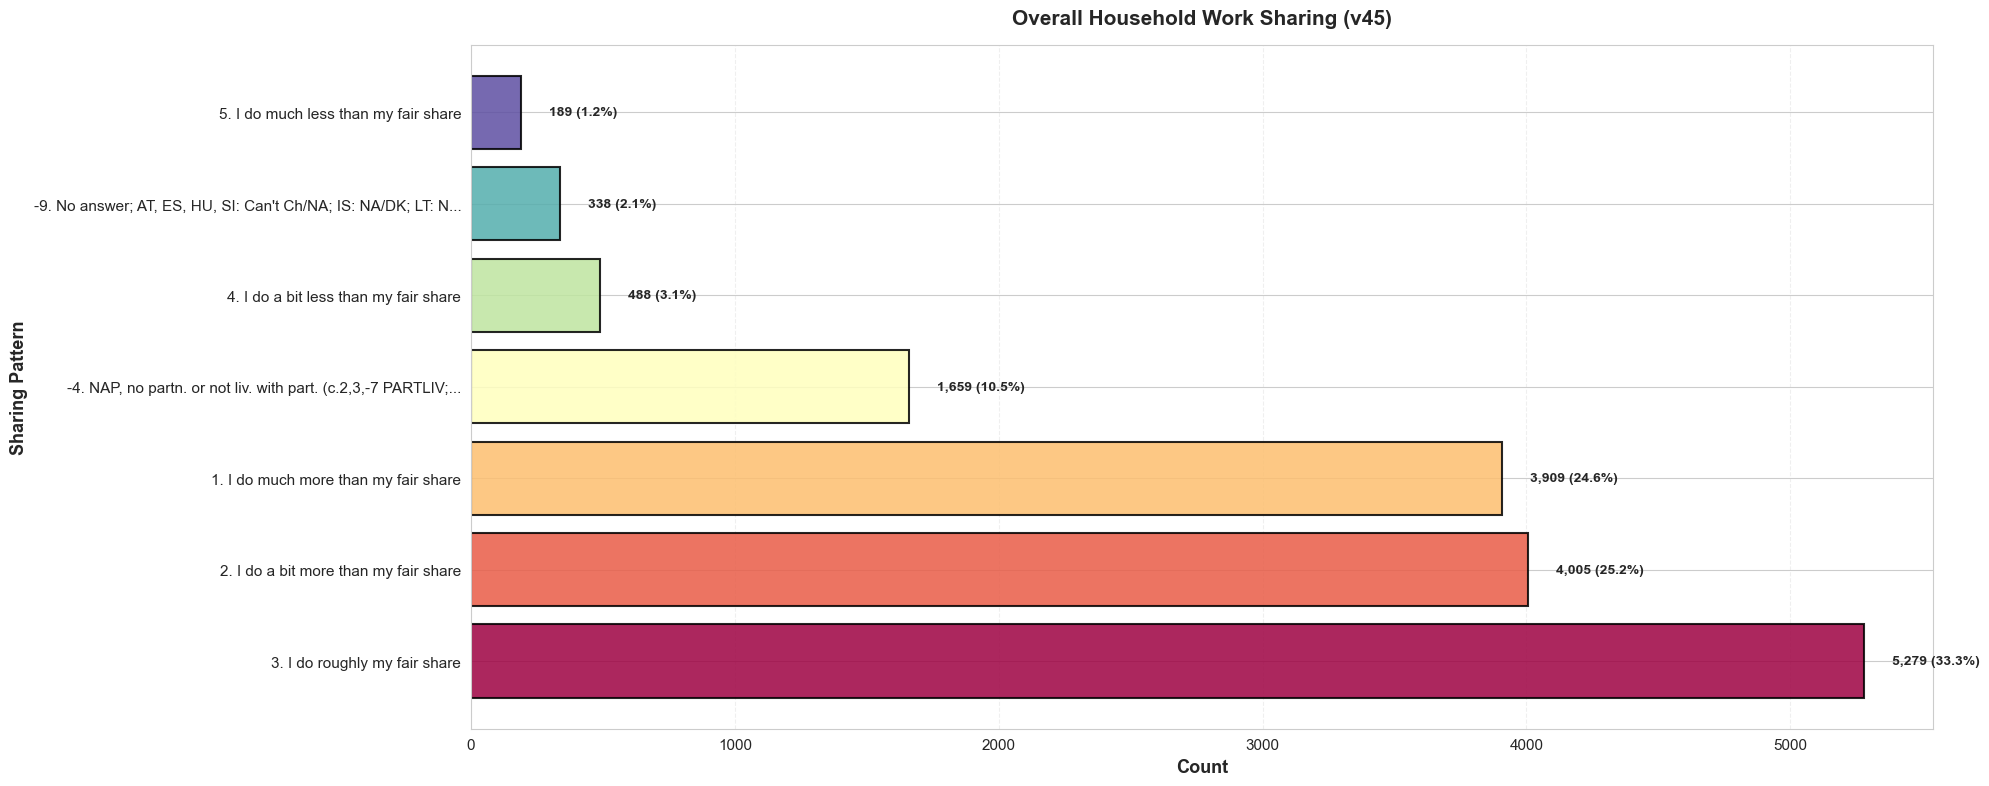

In [ ]:
# Overall household work sharing
sharing_dist = df_women_partnered['v45'].value_counts()

fig, ax = plt.subplots(figsize=(20, 8))

# Bar plot
colors_bar = plt.cm.Spectral(np.linspace(0, 1, len(sharing_dist)))
bars = ax.barh(range(len(sharing_dist)), sharing_dist.values, 
                color=colors_bar, alpha=0.85, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(sharing_dist)))
# Truncate long labels
labels = [str(label)[:60] + '...' if len(str(label)) > 60 else str(label) 
         for label in sharing_dist.index]
ax.set_yticklabels(labels, fontsize=11)
ax.set_title('Overall Household Work Sharing (v45)', fontsize=15, fontweight='bold', pad=15)
ax.set_xlabel('Count', fontsize=13, fontweight='bold')
ax.set_ylabel('Sharing Pattern', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for i, v in enumerate(sharing_dist.values):
    pct = v / sharing_dist.sum() * 100
    ax.text(v + sharing_dist.max()*0.02, i, f'{v:,} ({pct:.1f}%)', 
             va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## 12. Household Work Sharing by Women's Employment Status

In [ ]:
# Cross-tabulation: household sharing vs women's work status
sharing_by_work = pd.crosstab(
    df_women_partnered['v45'], 
    df_women_partnered['work_simple'],
    normalize='columns'
) * 100

In [ ]:
sharing_by_work

work_simple,Not Working,Working
v45,,
"-9. No answer; AT, ES, HU, SI: Can't Ch/NA; IS: NA/DK; LT: NA/DK/Hard to say; PL: Hard to say/NA",2.473667,1.906051
"-4. NAP, no partn. or not liv. with part. (c.2,3,-7 PARTLIV; US: c.2 (if neither married nor cohabit. with partner), 3 PARTL",10.788382,10.238517
1. I do much more than my fair share,28.215768,22.299760
2. I do a bit more than my fair share,22.725822,26.882616
3. I do roughly my fair share,31.311842,34.548485
4. I do a bit less than my fair share,2.872646,3.207999
5. I do much less than my fair share,1.611874,0.916571


In [ ]:
sharing_by_work = sharing_by_work.rename({"-9. No answer; AT, ES, HU, SI: Can't Ch/NA; IS: NA/DK; LT: NA/DK/Hard to say; PL: Hard to say/NA":"-9 Hard to say", '-4. NAP, no partn. or not liv. with part. (c.2,3,-7 PARTLIV; US: c.2 (if neither married nor cohabit. with partner), 3 PARTL':'-4. NOt applicable'})

Household Work Sharing by Women's Employment Status
(% within each work status):

work_simple                            Not Working  Working
v45                                                        
-9 Hard to say                                2.47     1.91
-4. NOt applicable                           10.79    10.24
1. I do much more than my fair share         28.22    22.30
2. I do a bit more than my fair share        22.73    26.88
3. I do roughly my fair share                31.31    34.55
4. I do a bit less than my fair share         2.87     3.21
5. I do much less than my fair share          1.61     0.92


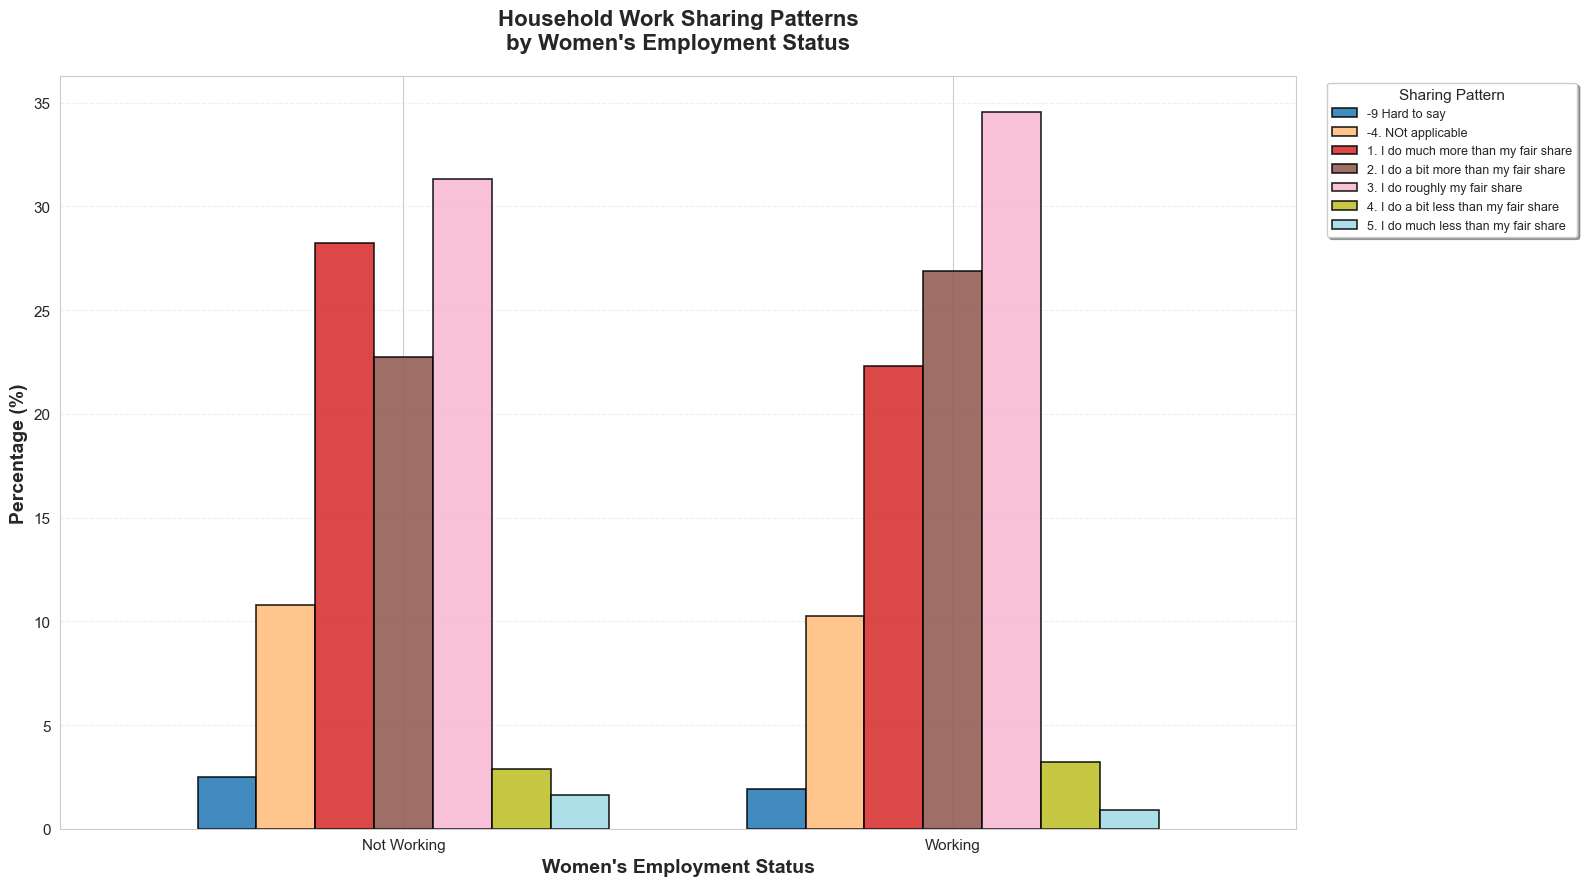

In [ ]:


print("Household Work Sharing by Women's Employment Status")
print("(% within each work status):")
print("\n" + "="*70)
print(sharing_by_work.round(2))
print("="*70)

# Visualization
fig, ax = plt.subplots(figsize=(16, 9))
sharing_by_work.T.plot(kind='bar', ax=ax, width=0.75, colormap='tab20', 
                       edgecolor='black', linewidth=1.2, alpha=0.85)
ax.set_title('Household Work Sharing Patterns\nby Women\'s Employment Status', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Women\'s Employment Status', fontsize=14, fontweight='bold')
ax.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
ax.legend(title='Sharing Pattern', fontsize=9, title_fontsize=11,
          bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

## 13. Partner's Employment Status Analysis

In [ ]:
partner_work.rename({'-4. NAP (c. 3,-7 PARTLIV; US: c. 2 (if neither married nor cohabitating with partner),3 PARTLIV ; AT: code 3-6 in MARITAL)':'-4. Not applicable'})

SPWORK
1. Currently in paid work                               10525
2. Currently not in paid work, paid work in the past     4047
3. Never had paid work                                    613
-9. No answer                                             511
-4. Not applicable                                        171
Name: count, dtype: int64

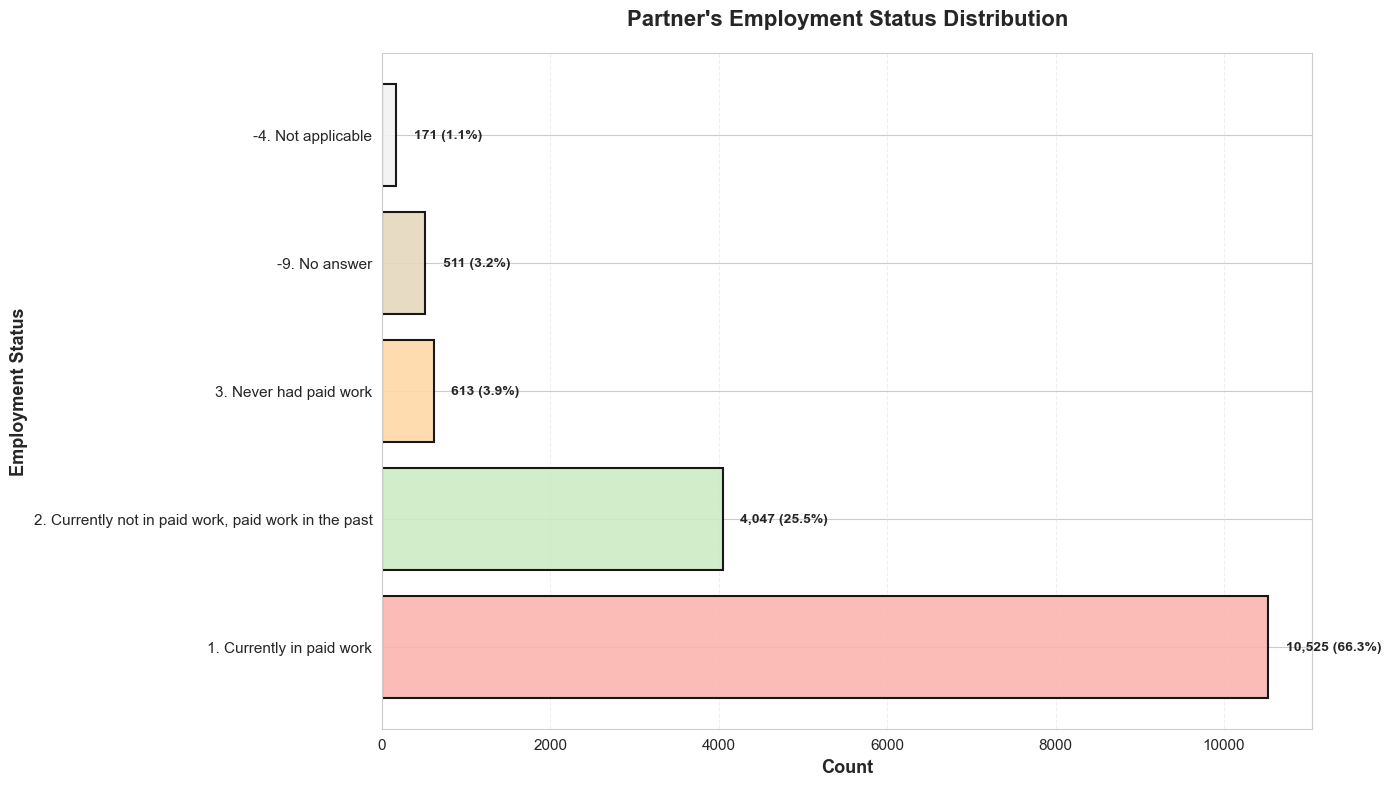


Dual Employment Patterns:
             Partner Not Working  Partner Working  Total
work_simple                                             
Not Working                 3753             2513   6266
Working                     1589             8012   9601
All                         5342            10525  15867

Dual-earner couples: 8,012 (50.5% of all partnered women)


In [ ]:
# Partner's work status distribution
partner_work = df_women_partnered['SPWORK'].value_counts()

partner_work = partner_work.rename({'-4. NAP (c. 3,-7 PARTLIV; US: c. 2 (if neither married nor cohabitating with partner),3 PARTLIV ; AT: code 3-6 in MARITAL)':'-4. Not applicable'})

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.Pastel1(np.linspace(0, 1, len(partner_work)))
bars = ax.barh(range(len(partner_work)), partner_work.values, 
               color=colors, alpha=0.9, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(partner_work)))
ax.set_yticklabels(partner_work.index, fontsize=11)
ax.set_title('Partner\'s Employment Status Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Count', fontsize=13, fontweight='bold')
ax.set_ylabel('Employment Status', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for i, v in enumerate(partner_work.values):
    pct = v / partner_work.sum() * 100
    ax.text(v + partner_work.max()*0.02, i, f'{v:,} ({pct:.1f}%)', 
            va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Cross-tabulation: Women's work vs Partner's work
dual_employment = pd.crosstab(
    df_women_partnered['work_simple'],
    df_women_partnered['SPWORK'].astype(str).str.contains('Currently in paid work', na=False),
    margins=True
)
dual_employment.columns = ['Partner Not Working', 'Partner Working', 'Total']

print("\nDual Employment Patterns:")
print(dual_employment)

# Calculate dual-earner percentage
both_working = len(df_women_partnered[
    (df_women_partnered['is_working'] == 1) & 
    (df_women_partnered['SPWORK'].astype(str).str.contains('Currently in paid work', na=False))
])
dual_pct = both_working / len(df_women_partnered) * 100
print(f"\nDual-earner couples: {both_working:,} ({dual_pct:.1f}% of all partnered women)")

## 14. Income Sharing Analysis

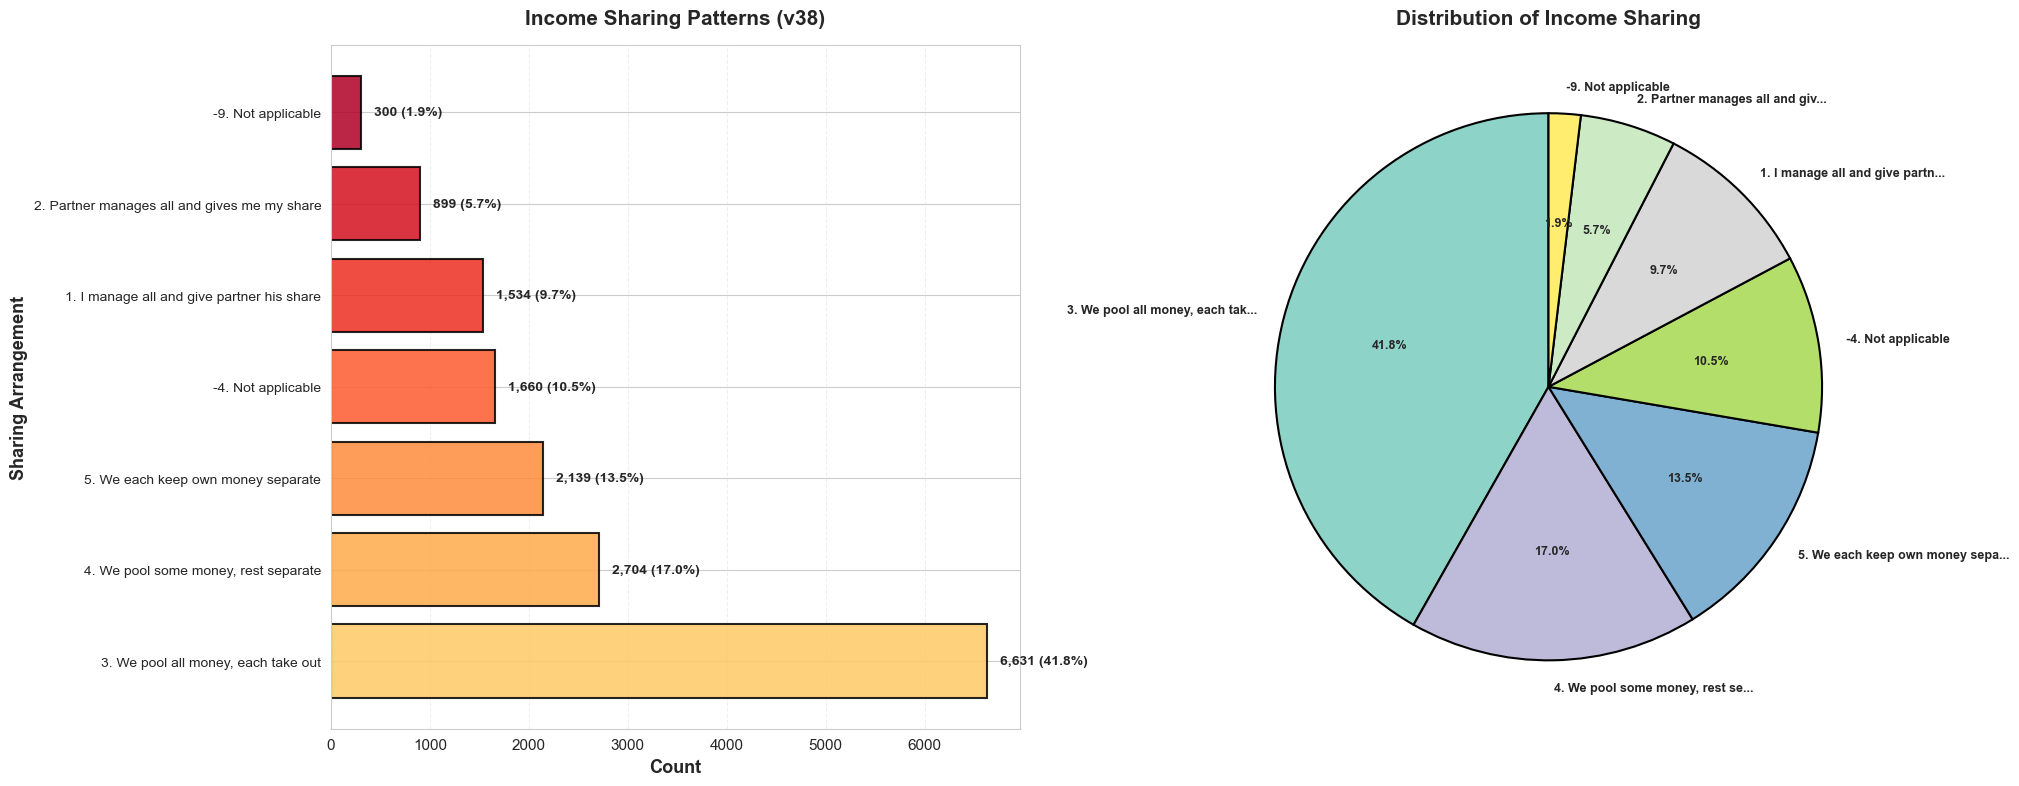

In [ ]:
# Income sharing patterns
income_sharing = df_women_partnered['v38'].value_counts()

income_sharing = income_sharing.rename({'-4. NAP, no partn. or not liv. with part. (c.2,3,-7 PARTLIV; US: c.2 (if neither married nor cohabit. with partner), 3 PARTL':'-4. Not applicable', "-9. No answer; AT, ES, NL: Can't Ch/NA; IS: NA/DK; LT: NA/DK/Hard to say; TW: Others": '-9. Not applicable'})


fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Bar chart
colors_bar = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(income_sharing)))
bars = axes[0].barh(range(len(income_sharing)), income_sharing.values, 
                    color=colors_bar, alpha=0.85, edgecolor='black', linewidth=1.5)
axes[0].set_yticks(range(len(income_sharing)))
# Truncate long labels
labels = [str(label)[:50] + '...' if len(str(label)) > 50 else str(label) 
         for label in income_sharing.index]
axes[0].set_yticklabels(labels, fontsize=10)
axes[0].set_title('Income Sharing Patterns (v38)', fontsize=15, fontweight='bold', pad=15)
axes[0].set_xlabel('Count', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Sharing Arrangement', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3, linestyle='--')

for i, v in enumerate(income_sharing.values):
    pct = v / income_sharing.sum() * 100
    axes[0].text(v + income_sharing.max()*0.02, i, f'{v:,} ({pct:.1f}%)', 
                va='center', fontweight='bold', fontsize=10)

# Pie chart
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(income_sharing)))
pie_labels = [str(label)[:30] + '...' if len(str(label)) > 30 else str(label) 
             for label in income_sharing.index]
wedges, texts, autotexts = axes[1].pie(income_sharing.values, labels=pie_labels,
                                        autopct='%1.1f%%', colors=colors_pie, 
                                        startangle=90, textprops={'fontsize': 9, 'weight': 'bold'},
                                        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
axes[1].set_title('Distribution of Income Sharing', fontsize=15, fontweight='bold', pad=15)

plt.tight_layout()
plt.show()

## 15. Country-Level Comparison

Women's Employment Rate by Country (Top 15):
               employment_rate  count
country_name                         
Israel                   83.58    469
Hungary                  78.88    322
Norway                   74.39    488
Croatia                  70.46    501
Switzerland              68.84    966
Greece                   67.81    494
Finland                  66.73    514
France                   65.14    786
Austria                  64.49    445
Iceland                  64.00    525
United States            63.99    311
Taiwan                   63.78    566
Bulgaria                 63.19    383
Japan                    62.53    459
Germany                  62.52    555


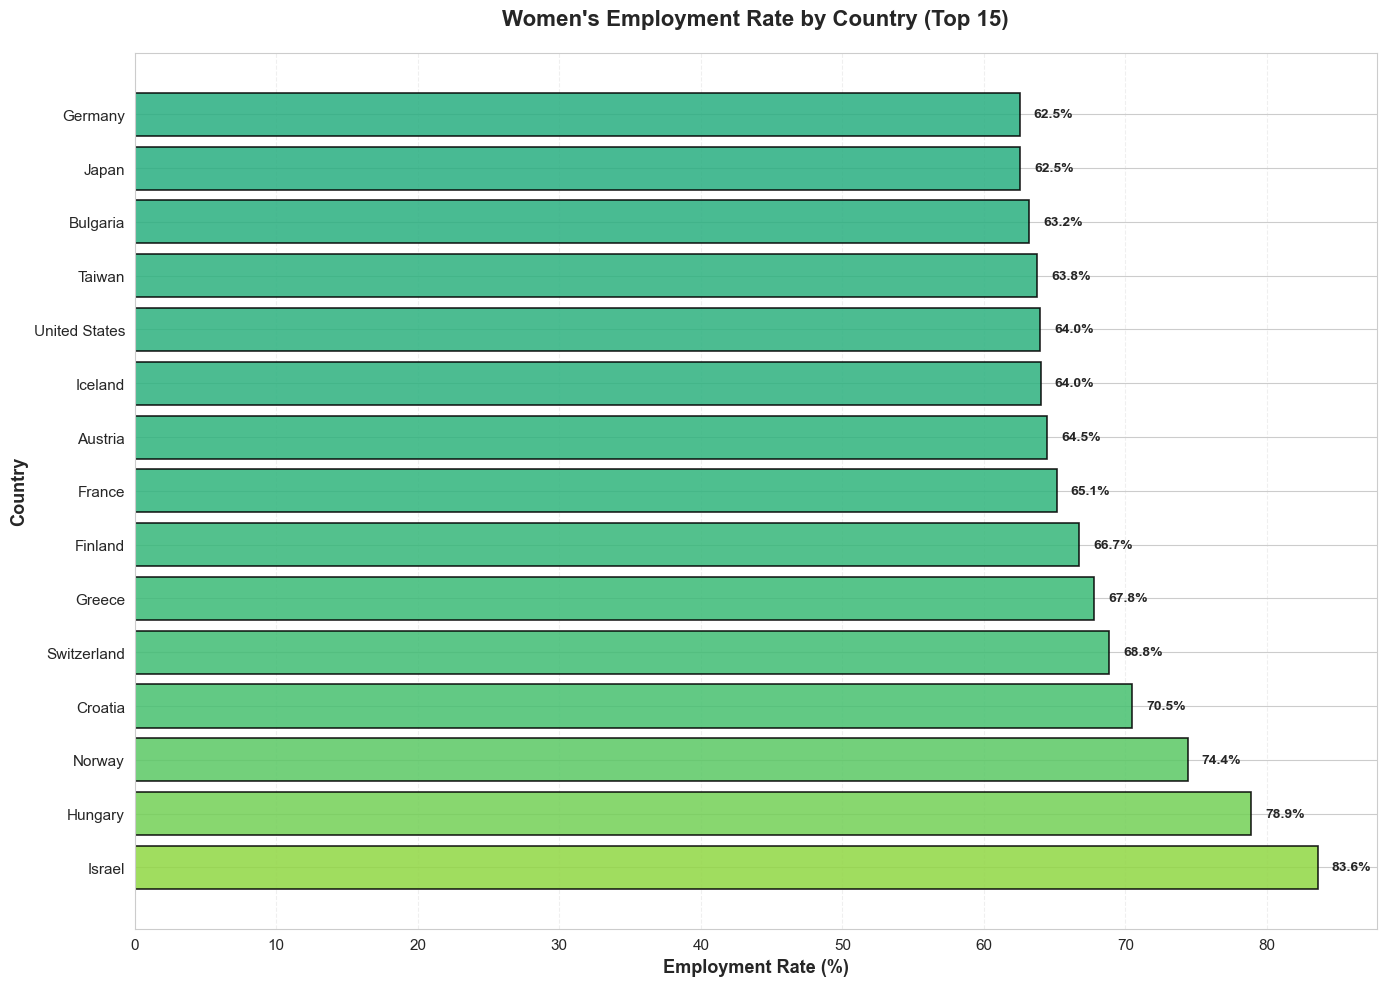

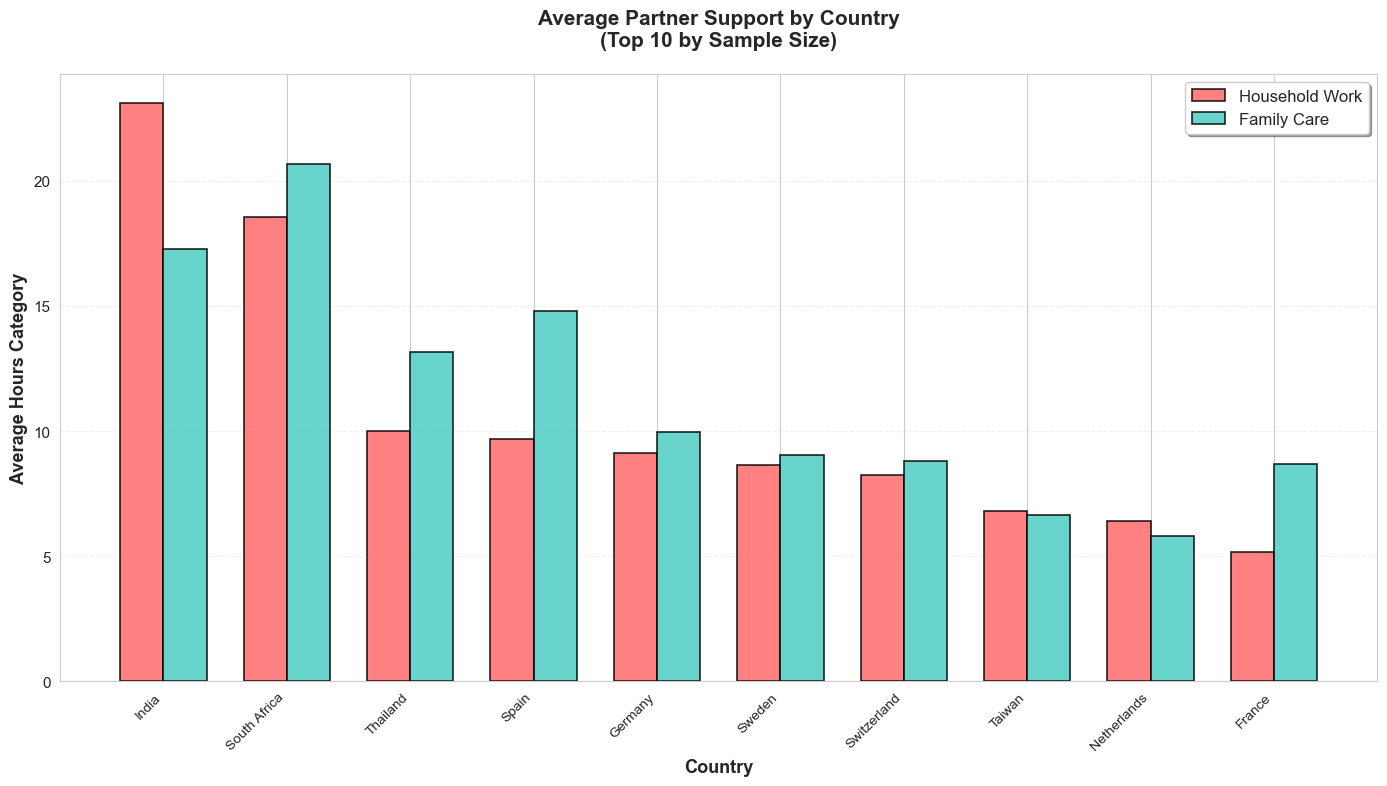

In [ ]:
# Women's employment rate by country
country_employment = df_women_partnered.groupby('country_name')['is_working'].agg(['sum', 'count'])
country_employment['employment_rate'] = (country_employment['sum'] / country_employment['count'] * 100).round(2)
country_employment = country_employment.sort_values('employment_rate', ascending=False)

print("Women's Employment Rate by Country (Top 15):")
print(country_employment[['employment_rate', 'count']].head(15))

# Plot top 15 countries
fig, ax = plt.subplots(figsize=(14, 10))
top_15 = country_employment.head(15)
colors = plt.cm.viridis(top_15['employment_rate'].values / 100)
bars = ax.barh(range(len(top_15)), top_15['employment_rate'].values, 
               color=colors, edgecolor='black', linewidth=1.2, alpha=0.85)
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15.index, fontsize=11)
ax.set_title('Women\'s Employment Rate by Country (Top 15)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Employment Rate (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Country', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for i, v in enumerate(top_15['employment_rate'].values):
    ax.text(v + 1, i, f'{v:.1f}%', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Average partner household support by country (top 10 countries by sample size)
top_countries = df_women_partnered['country_name'].value_counts().head(10).index
# Convert to numeric before filtering
v36_numeric = pd.to_numeric(df_women_partnered['v36_num'], errors='coerce')
v37_numeric = pd.to_numeric(df_women_partnered['v37_num'], errors='coerce')

df_top_countries = df_women_partnered[
    (df_women_partnered['country_name'].isin(top_countries)) &
    (v36_numeric >= 0) &
    (v37_numeric >= 0)
].copy()

# Ensure numeric columns after copy
df_top_countries.loc[:, 'v36_num'] = pd.to_numeric(df_top_countries['v36_num'], errors='coerce')
df_top_countries.loc[:, 'v37_num'] = pd.to_numeric(df_top_countries['v37_num'], errors='coerce')

country_support = df_top_countries.groupby('country_name')[['v36_num', 'v37_num']].mean().sort_values('v36_num', ascending=False)
country_support.columns = ['Household Work', 'Family Care']

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(country_support))
width = 0.35

bars1 = ax.bar(x - width/2, country_support['Household Work'], width, 
               label='Household Work', color='#FF6B6B', 
               edgecolor='black', linewidth=1.2, alpha=0.85)
bars2 = ax.bar(x + width/2, country_support['Family Care'], width, 
               label='Family Care', color='#4ECDC4', 
               edgecolor='black', linewidth=1.2, alpha=0.85)

ax.set_title('Average Partner Support by Country\n(Top 10 by Sample Size)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel('Country', fontsize=13, fontweight='bold')
ax.set_ylabel('Average Hours Category', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(country_support.index, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=12, frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()